# Strategy Simulation (fast version)

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import financial.data as fd
import financial.portfolio as fp
import financial.strategies.simulation as fss

import os

In [95]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Desktop/TFG/OTRI/data
/home/manidmt/Desktop/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


# Signals

In [96]:
import financial.strategies.technical.indicator as st

# Momentum
    
momentum1m = st.Momentum()
momentum1m.set_parameters({'delay': 20})

momentum3m = st.Momentum()
momentum3m.set_parameters({'delay': 60})

momentum4m = st.Momentum()
momentum4m.set_parameters({'delay': 84})

momentum6m = st.Momentum()
momentum6m.set_parameters({'delay': 126})

momentum8m = st.Momentum()
momentum8m.set_parameters({'delay': 168})

momentum9m = st.Momentum()
momentum9m.set_parameters({'delay': 189})
       
momentum1y = st.Momentum()
momentum1y.set_parameters({'delay': 252})
    
# Aggregation

indicator_ferrer = st.Mean()
indicator_ferrer.set_parameters({'components': [momentum4m.to_dict(), momentum6m.to_dict(), momentum8m.to_dict()]})
print(indicator_ferrer.to_dict())    
    
indicator_requejo = st.Mean() # st.Sum() # Average instead of sum to make it comparable
indicator_requejo.set_parameters({'components': [momentum1m.to_dict(), momentum3m.to_dict(), momentum6m.to_dict(), momentum9m.to_dict(), momentum1y.to_dict()]})
print(indicator_requejo.to_dict())  


{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 84}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 168}]}
{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 20}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 60}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 189}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 252}]}


In [97]:
from financial.momentum.exponentialIndicator import ExponentialRegressionIndicator

indicator_exponential = ExponentialRegressionIndicator()

# Strategies

In [98]:
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

# Asset Universe

universe_ferrer = ['XLI', 'XLF', 'XLV', 'XLK', 'XLC', 'XLU', 'XLY', 'XLB', 'XLE', 'XLP',
                    'TLT', 'TIP', 'IEF', 'SHY', 'AGG', 'VNQ', 'GLD', 'DBC'] # IAU excluded
    
universe_requejo = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'XOP',
                    'XHB', 'XME', 'XRT', 'XTL', 'TLT', 'DBC']
    
universe_ing = ['XLI', 'XLF', 'XLV', 'XLK', 'XLY', 'XLB', 'XLP', 
                'SPY', 'DJE', 'NASD', 
                'IOGP', 'IQQH', 'RBOT', 'HEAL', 
                'PHAU', 'LYTR', 'GLRE']

universe_ing_eur = ['ZPDM', 'ZPDI', 'ZPDS', 'ZPDH', 'ZPDT', 'ZPDD', 'ZPDF',
                   'SPY5', 'DJE', 'UST', 'LYTR', 'IQQH'] # , 'IOGP', 'GLRE', 'PHAU', 'HEAL', 'RBOT']

from typing import List

def universe_report(tickers: List[str]):
    for ticker in tickers:
        metadata = ds.get_metadata(ticker)
        #print(metadata)
        print(f"{ticker:4} {metadata['currency']} {metadata['since']} {metadata['isin']} {metadata['description']}")

print("HUGO FERRER'S UNIVERSE")
universe_report(universe_ferrer)

print("DANIEL REQUEJO'S UNIVERSE")
universe_report(universe_requejo)

print("ING'S UNIVERSE")
universe_report(universe_ing)

print("ING'S UNIVERSE [EUR]")
universe_report(universe_ing_eur)


# Asset ranking strategies

ferrer_refuge = None # refuge
ferrer_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=10), fsf.MinimumValueAssetFilter(threshold=0.0)] )
ferrer_allocation = fsa.FixedWeightAllocation(0.10)
ferrer_strategy = fsr.AssetRankingStrategy("HUGO FERRER'S STRATEGY", universe_ferrer,indicator_ferrer, ferrer_filter, ferrer_allocation, ferrer_refuge)
print(ferrer_strategy)

requejo_filter = fsf.TopKAssetFilter(k=3)
requejo_allocation = fsa.EqualWeightAllocation()
requejo_strategy = fsr.AssetRankingStrategy("DANIEL REQUEJO'S STRATEGY", universe_requejo, indicator_requejo, requejo_filter, requejo_allocation)    
print(requejo_strategy)

ferrer_strategy_ing = fsr.AssetRankingStrategy("ING @ Ferrer's strategy", universe_ing_eur, indicator_ferrer, ferrer_filter, ferrer_allocation)
print(ferrer_strategy_ing)

requejo_strategy_ing = fsr.AssetRankingStrategy("ING @ Requejo's strategy", universe_ing_eur, indicator_requejo, requejo_filter, requejo_allocation)
print(requejo_strategy_ing)





assets = {'DFF': 1.0}
target = fp.WeightedPortfolio.from_assets("Exp Refuge", assets)
exp_filter = fsf.TopKAssetFilter(k=7)
exp_allocation = fsa.EqualWeightAllocation()
exp_strategy = fsr.AssetRankingStrategy("Exponential Strategy", universe_ferrer, indicator_exponential, exp_filter, exp_allocation)
print(exp_strategy)


HUGO FERRER'S UNIVERSE
XLI  USD 02/01/2001 US81369Y7040 Industrial SPDR Select Sector ETF
XLF  USD 30/03/2001 US81369Y6059 Financial SPDR Select Sector ETF
XLV  USD 02/01/2001 US81369Y2090 Health Care SPDR Select Sector ETF
XLK  USD 02/01/2001 US81369Y8030 Technology SPDR Select Sector ETF
XLC  USD 20/06/2018 US81369Y8527 Communication Services SPDR Select Sector ETF
XLU  USD 27/11/2017 US81369Y8865 Utilities SPDR Select Sector ETF
XLY  USD 02/01/2001 US81369Y4070 Consumer Discretionary SPDR Select Sector ETF
XLB  USD 02/01/2001 US81369Y1001 Materials SPDR Select Sector ETF
XLE  USD 30/03/2001 US81369Y5069 Energy SPDR Select Sector ETF
XLP  USD 02/01/2001 US81369Y3080 Consumer Staples SPDR Select Sector ETF
TLT  USD 30/07/2002 US4642874329 US Bond 20+yr iShares ETF
TIP  USD 05/12/2003 US4642871762 US TIPS Bond iShares ETF
IEF  USD 07/07/2015 US4642874402 US Bond 7-10yr iShares ETF NASDAQ
SHY  USD 07/07/2015 US4642874576 US Bond 1-3yr iShares ETF NASDAQ
AGG  USD 29/09/2003 US4642872265 

# Porfolio performance

In [99]:
portfolio = fp.StockPortfolio("Stocks")
portfolio.add('$$$', '2001-01-01', 1000000, 1000000)

print(portfolio)

for ticker in portfolio.lots:
    print(portfolio.lots[ticker])
    
print(f"- Cost:  ${portfolio.cost():10.2f}")
print(f"- Value: ${portfolio.value(ds):10.2f}")
print(f"- Gain:  ${portfolio.gain(ds):>10.2f}  {100*portfolio.gain(ds)/portfolio.cost():>6.2f}%")
print()

fss.SimulationReport.value_report(ds,portfolio,start_year=2000)
print()
fss.SimulationReport.performance_report(ds,portfolio,start_year=2000)
fss.SimulationReport.performance_report_stocks(ds,portfolio,start_year=2000)


Stocks: ['$$$']
$$$: [{'index': '2001-01-01', 'stocks': 1000000, 'cost': 1000000}]
- Cost:  $1000000.00
- Value: $1000000.00
- Gain:  $      0.00    0.00%

           YEAR        Jan        Feb        Mar        Apr        May        Jun        Jul        Aug        Sep        Oct        Nov        Dec
  2000:       0.00                                                                                                
  2001: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2002: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2003: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2004: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00

  2006:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2007:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2008:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2009:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2010:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2011:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2012:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2013:    0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%   0.00%
  2014:    0.00%   0.00%   0.00%

In [100]:
import financial.portfolios.statistics as fps

assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
print(target)

print("Daily returns")
benchmark_returns = target.returns(ds,'2015-12-31','2023-12-31')
print(benchmark_returns)
print("Monthly returns")
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2016,2023)
print(benchmark_monthly_returns)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
print("Cumulative returns")
print(benchmark_cumulative_returns)


fss.SimulationReport.performance_report(ds, target, 2001)

print("\n Cumulative return")
fss.SimulationReport.cumulative_report(ds, target, 2001)


Target:
      ticker  weight  cost  isin description
^GSPC  ^GSPC     1.0  None  None        None
Daily returns
2016-01-04   -0.015304
2016-01-05    0.002012
2016-01-06   -0.013115
2016-01-07   -0.023700
2016-01-08   -0.010838
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Length: 2012, dtype: float64
Monthly returns
2016-01-31   -0.050735
2016-02-29   -0.004128
2016-03-31    0.065991
2016-04-30    0.002699
2016-05-31    0.015325
                ...   
2023-08-31   -0.017716
2023-09-30   -0.048719
2023-10-31   -0.021980
2023-11-30    0.089179
2023-12-31    0.044229
Name: return, Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.050735
2016-02-29   -0.054654
2016-03-31    0.007730
2016-04-30    0.010450
2016-05-31    0.025935
                ...   
2023-08-31    1.205378
2023-09-30    1.097933
2023-10-31    1.051821
2023-11-30    1.234801
2023-12-31    1.333645
Name: return, Length: 96

# Strategy simulation 

In [101]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy = exp_strategy #ferrer_strategy_ing #ferrer_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(+2,market) # +1 first day, -1 last day

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)
        
simulation = fss.FastStockStrategySimulation(ds, strategy, rebalancing, market)
#simulation.verbose = True  # verbose 30.4s vs. 15.4s without trading details
simulation.simulate(start_year=2016, end_year=2023)


STRATEGY
Exponential Strategy
- 18 asset universe: ['XLI', 'XLF', 'XLV', 'XLK', 'XLC', 'XLU', 'XLY', 'XLB', 'XLE', 'XLP', 'TLT', 'TIP', 'IEF', 'SHY', 'AGG', 'VNQ', 'GLD', 'DBC']
- Indicator: {'type': 'financial.momentum.exponentialIndicator.ExponentialRegressionIndicator', 'lookahead': 20, 'horizon': 90, 'model': 'exponential'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on 2
SIMULATING 2016...
+ Rebalance @ 2015-12-01
{'XLK': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLI': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLB': 0.14285714285714285, 'XLP': 0.14285714285714285}
+ Trade @ 2015-12-02
- Changes: {'XLE': 2150, 'XLP': 2880, 'XLB': 3144, 'XLY': 1765, 'XLI': 2624, '$$$': -999764.4019851686, 'VNQ': 1811, 'XLK': 3241}
- Rotation: 99.98%
+ Rebalance @ 2015-12-31
{'XLK': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLP': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLB': 0.14

- Changes: {'XLF': 135, 'DBC': -58, 'XLE': 110, 'XLB': -80, 'XLY': -38, '$$$': -89.87952041628887, 'XLI': 5, 'XLK': -61}
- Rotation: 1.12%
+ Rebalance @ 2017-03-01
{'XLF': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLB': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLY': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLV': 0.14285714285714285}
+ Trade @ 2017-03-02
- Changes: {'XLF': -256, 'DBC': -9203, 'XLE': -2013, 'XLB': 30, 'XLY': -8, '$$$': 72.16370868691592, 'XLI': -52, 'XLV': 1989, 'VNQ': 1776, 'XLK': -62}
- Rotation: 28.72%
+ Rebalance @ 2017-03-31
{'XLK': 0.14285714285714285, 'XLV': 0.14285714285714285, 'XLU': 0.14285714285714285, 'XLP': 0.14285714285714285, 'XLF': 0.14285714285714285, 'XLY': 0.14285714285714285, 'GLD': 0.14285714285714285}
+ Trade @ 2017-04-03
- Changes: {'XLF': 210, 'XLP': 2718, 'XLB': -2849, 'XLY': -32, '$$$': 41.79580307009746, 'XLI': -2268, 'XLU': 2887, 'XLV': 1, 'VNQ': -1776, 'GLD': 1241, 'XLK': -66}
- Rotation: 43.34%
+ Rebalance @ 2017-05

- Changes: {'DBC': 2, 'XLE': 1889, 'TIP': 20, 'XLY': -1369, '$$$': 260.6152687072463, 'XLU': 125, 'SHY': 23, 'VNQ': 1790, 'GLD': -1141, 'XLK': -135}
- Rotation: 29.63%
+ Rebalance @ 2018-06-29
{'XLE': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'DBC': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLU': 0.14285714285714285, 'TLT': 0.14285714285714285}
+ Trade @ 2018-07-02
- Changes: {'DBC': 200, 'TIP': -1280, '$$$': -169.38359832769493, 'XLU': -131, 'TLT': 1181, 'VNQ': -19, 'XLK': 49, 'XLE': 27, 'XLY': 1310, 'SHY': -1719}
- Rotation: 29.45%
+ Rebalance @ 2018-08-01
{'XLY': 0.14285714285714285, 'XLK': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLV': 0.14285714285714285, 'XLU': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2018-08-02
- Changes: {'DBC': -8284, 'XLB': 2459, '$$$': -173.5069694519625, 'TLT': -1181, 'XLV': 1617, 'VNQ': -13, 'XLK': -52, 'XLE': -6, 'XLY': -14}
- Rotation: 28.56%
+ Rebalance @ 2

- Changes: {'XLP': 1, '$$$': 92.74987411499023, 'XLU': 40, 'TLT': 49, 'IEF': 30, 'VNQ': -14, 'GLD': 4, 'XLK': -142}
- Rotation: 1.22%
+ Rebalance @ 2019-11-29
{'XLF': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLV': 0.14285714285714285, 'XLU': 0.14285714285714285, 'VNQ': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2019-12-02
- Changes: {'XLP': -2584, 'XLB': 2625, '$$$': 98.63009262070409, 'XLU': 17, 'TLT': -1128, 'IEF': -1403, 'XLV': 1575, 'VNQ': 29, 'GLD': -1101, 'XLK': -44, 'XLF': 5208, 'XLI': 1933}
- Rotation: 57.48%
+ Rebalance @ 2019-12-31
{'XLV': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLF': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLB': 0.14285714285714285, 'XLC': 0.14285714285714285, 'DBC': 0.14285714285714285}
FINAL PORTFOLIO @ 2019
Stocks: ['$$$', 'XLP', 'XLU', 'TLT', 'IEF', 'SHY', 'AGG', 'GLD', 'TIP', 'XLY', 'XLI', 'VNQ', 'XLC', 'XLB', 'XLK', 'XLE', 'XLF', 'XLV']
Portfolio value: 1148498.87
Portfolio assets

- Changes: {'XLF': -81, 'XLE': 3761, 'XLC': 22, 'XLB': -24, 'XLY': -11, '$$$': -335.35918617251446, 'XLI': 28, 'XLU': -2242, 'XLK': -27}
- Rotation: 14.67%
+ Rebalance @ 2021-02-01
{'XLE': 0.14285714285714285, 'XLF': 0.14285714285714285, 'XLB': 0.14285714285714285, 'DBC': 0.14285714285714285, 'XLI': 0.14285714285714285, 'XLC': 0.14285714285714285, 'XLK': 0.14285714285714285}
+ Trade @ 2021-02-02
- Changes: {'XLF': 21, 'DBC': 9495, 'XLE': -60, 'XLC': -5, 'XLB': 53, 'XLY': -896, '$$$': 140.2559986114793, 'XLI': 41, 'XLK': -11}
- Rotation: 15.08%
+ Rebalance @ 2021-03-01
{'XLE': 0.14285714285714285, 'XLF': 0.14285714285714285, 'DBC': 0.14285714285714285, 'XLK': 0.14285714285714285, 'XLC': 0.14285714285714285, 'XLY': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2021-03-02
- Changes: {'XLF': -117, 'DBC': 96, 'XLE': -448, 'XLC': 51, 'XLB': 62, 'XLY': 980, '$$$': 104.22836685192306, 'XLI': -1693, 'XLK': 97}
- Rotation: 16.34%
+ Rebalance @ 2021-04-01
{'XLE': 0.14285714285714285,

- Changes: {'DBC': -81, 'XLE': -191, 'XLP': 137, 'XLB': 17, '$$$': -74.45081901553203, 'XLU': -31, 'XLV': 32, 'GLD': 33}
- Rotation: 2.01%
+ Rebalance @ 2022-07-01
{'DBC': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLU': 0.14285714285714285, 'SHY': 0.14285714285714285, 'XLP': 0.14285714285714285, 'XLV': 0.14285714285714285, 'XLB': 0.14285714285714285}
+ Trade @ 2022-07-05
- Changes: {'DBC': 341, 'XLE': 242, 'XLP': -161, 'XLB': 147, '$$$': -98.63415336623439, 'XLU': -66, 'SHY': 1667, 'XLV': -98, 'GLD': -882}
- Rotation: 18.01%
+ Rebalance @ 2022-08-01
{'SHY': 0.14285714285714285, 'IEF': 0.14285714285714285, 'DBC': 0.14285714285714285, 'AGG': 0.14285714285714285, 'TIP': 0.14285714285714285, 'XLE': 0.14285714285714285, 'XLU': 0.14285714285714285}
+ Trade @ 2022-08-02
- Changes: {'DBC': 113, 'XLP': -1902, 'XLB': -1904, 'TIP': 1242, '$$$': 98.38035202017636, 'XLU': -46, 'IEF': 1381, 'XLV': -1073, 'XLE': -106, 'SHY': 73, 'AGG': 1394}
- Rotation: 43.74%
+ Rebalance @ 2022-09-01
{'XLY':

- Changes: {'DBC': 5721, 'XLC': -68, 'XLB': 23, '$$$': 200.23911666864296, 'XLK': -840, 'XLF': -15, 'XLE': -28, 'XLY': 4, 'XLI': 23}
- Rotation: 14.78%
+ Rebalance @ 2023-11-01
{'XLE': 0.14285714285714285, 'DBC': 0.14285714285714285, 'SHY': 0.14285714285714285, 'XLC': 0.14285714285714285, 'GLD': 0.14285714285714285, 'XLV': 0.14285714285714285, 'TIP': 0.14285714285714285}
+ Trade @ 2023-11-02
- Changes: {'DBC': -12, 'XLC': -17, 'XLB': -1828, 'TIP': 1365, '$$$': 48.00896072384785, 'XLV': 1117, 'GLD': 769, 'XLF': -4309, 'XLE': 17, 'XLY': -879, 'XLI': -1411, 'SHY': 1748}
- Rotation: 57.28%
+ Rebalance @ 2023-12-01
{'XLK': 0.14285714285714285, 'GLD': 0.14285714285714285, 'XLC': 0.14285714285714285, 'SHY': 0.14285714285714285, 'DBC': 0.14285714285714285, 'TIP': 0.14285714285714285, 'AGG': 0.14285714285714285}
+ Trade @ 2023-12-04
- Changes: {'DBC': 317, 'XLC': -70, 'TIP': -8, '$$$': -364.8766098021879, 'XLV': -1117, 'GLD': -10, 'XLK': 777, 'XLE': -1617, 'AGG': 1476}
- Rotation: 29.31%
+ Reba

In [102]:
simulation.portfolio_target_report()


2015-12-01: {'XLK': 0.14, 'XLY': 0.14, 'XLI': 0.14, 'VNQ': 0.14, 'XLE': 0.14, 'XLB': 0.14, 'XLP': 0.14}
2015-12-31: {'XLK': 0.14, 'XLY': 0.14, 'XLP': 0.14, 'VNQ': 0.14, 'XLI': 0.14, 'XLB': 0.14, 'XLF': 0.14}
2016-02-01: {'XLP': 0.14, 'TLT': 0.14, 'XLV': 0.14, 'XLU': 0.14, 'VNQ': 0.14, 'XLK': 0.14, 'IEF': 0.14}
2016-03-01: {'TLT': 0.14, 'XLU': 0.14, 'GLD': 0.14, 'IEF': 0.14, 'XLP': 0.14, 'AGG': 0.14, 'TIP': 0.14}
2016-04-01: {'GLD': 0.14, 'XLU': 0.14, 'TLT': 0.14, 'XLP': 0.14, 'IEF': 0.14, 'VNQ': 0.14, 'TIP': 0.14}
2016-04-29: {'GLD': 0.14, 'XLB': 0.14, 'XLU': 0.14, 'XLE': 0.14, 'XLI': 0.14, 'VNQ': 0.14, 'XLK': 0.14}
2016-06-01: {'XLE': 0.14, 'XLB': 0.14, 'DBC': 0.14, 'XLI': 0.14, 'VNQ': 0.14, 'XLF': 0.14, 'XLY': 0.14}
2016-07-01: {'DBC': 0.14, 'XLE': 0.14, 'XLB': 0.14, 'VNQ': 0.14, 'XLU': 0.14, 'XLV': 0.14, 'XLF': 0.14}
2016-08-01: {'DBC': 0.14, 'VNQ': 0.14, 'XLE': 0.14, 'TLT': 0.14, 'XLU': 0.14, 'GLD': 0.14, 'XLV': 0.14}
2016-09-01: {'XLK': 0.14, 'VNQ': 0.14, 'TLT': 0.14, 'XLV': 0.14,

In [103]:
simulation.simulation_trading_report()

2015-12-02: 99.98% {'XLE': 2150, 'XLP': 2880, 'XLB': 3144, 'XLY': 1765, 'XLI': 2624, '$$$': -999764.4019851686, 'VNQ': 1811, 'XLK': 3241}
2016-01-04: 14.75% {'XLF': 7226, 'XLE': -2150, 'XLP': -128, 'XLB': 65, 'XLY': 20, '$$$': -205.12417221066426, 'VNQ': -69, 'XLK': 4}
2016-02-02: 57.13% {'XLF': -7226, 'XLP': -167, 'XLB': -3209, 'XLY': -1785, '$$$': -9.541839599682135, 'XLI': -2624, 'TLT': 1007, 'XLU': 2822, 'IEF': 1187, 'XLV': 1980, 'VNQ': -41, 'XLK': -47}
2016-03-02: 43.66% {'XLP': -13, 'TIP': 1176, '$$$': 332.42158508293505, 'XLU': 41, 'TLT': 21, 'IEF': 25, 'XLV': -1980, 'VNQ': -1701, 'GLD': 1117, 'XLK': -3198, 'AGG': 1211}
2016-04-04: 15.13% {'XLP': -49, 'TIP': 1, '$$$': -76.77640533455997, 'XLU': -134, 'TLT': 6, 'IEF': 15, 'VNQ': 1619, 'GLD': 47, 'AGG': -1211}
2016-05-02: 57.40% {'XLP': -2523, 'XLB': 2859, 'TIP': -1177, '$$$': -84.25014495867072, 'XLU': 40, 'TLT': -1034, 'IEF': -1227, 'VNQ': 7, 'GLD': -67, 'XLK': 3185, 'XLE': 2004, 'XLI': 2394}
2016-06-02: 43.02% {'DBC': 9055, 'XL

2020-11-02: 15.12% {'XLC': -16, 'XLP': 14, 'XLB': -73, '$$$': 218.89237976069853, 'XLU': 1988, 'GLD': -715, 'XLK': 31, 'XLY': 20, 'XLI': -16}
2020-12-02: 99.98% {'XLF': 4991, 'XLC': 2125, 'XLB': 2016, 'XLY': 907, 'XLI': 1624, '$$$': -999781.6112689973, 'XLU': 2242, 'XLK': 1144}
2021-01-04: 14.67% {'XLF': -81, 'XLE': 3761, 'XLC': 22, 'XLB': -24, 'XLY': -11, '$$$': -335.35918617251446, 'XLI': 28, 'XLU': -2242, 'XLK': -27}
2021-02-02: 15.08% {'XLF': 21, 'DBC': 9495, 'XLE': -60, 'XLC': -5, 'XLB': 53, 'XLY': -896, '$$$': 140.2559986114793, 'XLI': 41, 'XLK': -11}
2021-03-02: 16.34% {'XLF': -117, 'DBC': 96, 'XLE': -448, 'XLC': 51, 'XLB': 62, 'XLY': 980, '$$$': 104.22836685192306, 'XLI': -1693, 'XLK': 97}
2021-04-05: 29.59% {'XLF': -46, 'DBC': 362, 'XLE': 119, 'XLC': -17, 'XLB': -48, 'XLY': -980, '$$$': -179.13589477544883, 'XLI': 1656, 'VNQ': 1764, 'XLK': -1203}
2021-05-03: 0.74% {'XLF': -14, 'DBC': -388, 'XLE': 41, 'XLC': 55, 'XLB': -3, '$$$': -52.0698471069627, 'XLI': 26, 'VNQ': -12}
2021-0

In [104]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation (exponential strategy): {100*rotation:.2f}%")

Average monthly rotation (exponential strategy): 33.83%


In [105]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")
    

cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")



STRATEGY RETURNS
2016:   0.22%
2017:  18.02%
2018:  -1.93%
2019:  14.85%
2020:  -0.68%
2021:  27.21%
2022:  -3.51%
2023:   7.03%

CUMULATIVE RETURNS
2016:   0.22%
2017:  18.27%
2018:  15.99%
2019:  33.21%
2020:  32.31%
2021:  68.30%
2022:  62.39%
2023:  73.81%


In [106]:
simulation.simulation_year_report()

2016
- Cost:  $1000000.00
- Value: $ 981554.83
- Gain:  $ -18445.17   -1.84%
2017
- Cost:  $1000000.00
- Value: $1196673.31
- Gain:  $ 196673.31   19.67%
2018
- Cost:  $1000000.00
- Value: $1003327.58
- Gain:  $   3327.58    0.33%
2019
- Cost:  $1000000.00
- Value: $1148498.87
- Gain:  $ 148498.87   14.85%
2020
- Cost:  $1000000.00
- Value: $ 993172.19
- Gain:  $  -6827.81   -0.68%
2021
- Cost:  $1000000.00
- Value: $1297168.70
- Gain:  $ 297168.70   29.72%
2022
- Cost:  $1000000.00
- Value: $1003839.56
- Gain:  $   3839.56    0.38%
2023
- Cost:  $1000000.00
- Value: $1039290.35
- Gain:  $  39290.35    3.93%


In [107]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:             0.22%  -5.01%  -0.53%   3.39%  -0.19%  -0.24%   0.98%   1.01%  -2.09%  -0.44%  -2.25%   4.17%   1.74%
Monthly cumulative returns
  2016:             0.22%  -5.01%  -5.51%  -2.31%  -2.49%  -2.72%  -1.77%  -0.77%  -2.84%  -3.27%  -5.44%  -1.49%   0.22%

SERIES
Monthly returns
2016-01-31   -0.050099
2016-02-29   -0.005310
2016-03-31    0.033946
2016-04-30   -0.001911
2016-05-31   -0.002368
                ...   
2023-08-31   -0.021132
2023-09-30   -0.042011
2023-10-31   -0.029805
2023-11-30    0.034151
2023-12-31    0.021058
Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.050099
2016-02-29   -0.055142
2016-03-31   -0.023068
2016-04-30   -0.024935
2016-05-31   -0.027244
                ...   
2023-08-31    0.771009
2023-09-30    0.696607
2023-10-31    0.646039
2023-11-30    0.702254
2023-12-31    0.738101
Length: 96, dtype: float64
CPU times: user 20.9 s, sys: 3.71 ms, total: 20.9 s
Wall time: 21.1 s


In [108]:
import pandas as pd
benchmark_series = pd.Series(benchmark_monthly_returns)
difference = monthly_returns - benchmark_series
print(difference)

print("Better than benchmark")
print(sum(difference>0))
print(difference[difference>0])
print(sum(difference[difference>0]))

print("Worse than benchmark")
print(sum(difference<0))
print(difference[difference<0])
print(sum(difference[difference<0]))

2016-01-31    0.000637
2016-02-29   -0.001181
2016-03-31   -0.032045
2016-04-30   -0.004611
2016-05-31   -0.017692
                ...   
2023-08-31   -0.003415
2023-09-30    0.006708
2023-10-31   -0.007826
2023-11-30   -0.055028
2023-12-31   -0.023171
Length: 96, dtype: float64
Better than benchmark
35
2016-01-31    0.000637
2016-06-30    0.008933
2016-11-30    0.007542
2017-04-30    0.002280
2017-05-31    0.009172
2017-08-31    0.007672
2017-10-31    0.008178
2017-12-31    0.011400
2018-03-31    0.002434
2018-06-30    0.004585
2018-10-31    0.020825
2018-12-31    0.081701
2019-03-31    0.004063
2019-07-31    0.002281
2019-08-31    0.047331
2020-03-31    0.046956
2020-08-31    0.000744
2020-09-30    0.015420
2020-10-31    0.005028
2021-02-28    0.067828
2021-04-30    0.006912
2021-05-31    0.028861
2021-12-31    0.001773
2022-01-31    0.044394
2022-02-28    0.020893
2022-03-31    0.009365
2022-04-30    0.066518
2022-05-31    0.028767
2022-06-30    0.013554
2022-08-31    0.030282
2022-

In [109]:
drawdown = fps.MaximumDrawdown().get_series(monthly_returns)
print(drawdown)
print(min(drawdown))

benchmark_drawdown = fps.MaximumDrawdown().get_series(benchmark_returns) # benchmark_monthly_returns)
print(benchmark_drawdown)
print(min(benchmark_drawdown))

2016-01-31   -0.050099
2016-02-29   -0.055142
2016-03-31   -0.023068
2016-04-30   -0.024935
2016-05-31   -0.027244
                ...   
2023-08-31   -0.021132
2023-09-30   -0.062255
2023-10-31   -0.090205
2023-11-30   -0.059134
2023-12-31   -0.039321
Length: 96, dtype: float64
-0.18156423842433178
2016-01-04   -0.015304
2016-01-05   -0.013322
2016-01-06   -0.026263
2016-01-07   -0.049341
2016-01-08   -0.059645
                ...   
2023-12-22   -0.008742
2023-12-26   -0.004547
2023-12-27   -0.003123
2023-12-28   -0.002754
2023-12-29   -0.005573
Length: 2012, dtype: float64
-0.3392496000265328


In [110]:
%%time

simulation.simulation_performance_report()

         return     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:    0.22%    0.22%  -5.01%  -0.53%   3.39%  -0.19%  -0.24%   0.98%   1.01%  -2.09%  -0.44%  -2.25%   4.17%   1.74%
  2017:   18.27%   18.02%   1.36%   1.98%  -0.22%   1.14%   2.07%  -0.38%   1.40%   0.82%   1.41%   3.04%   2.00%   2.12%
  2018:   15.99%   -1.93%   5.52%  -4.66%  -2.45%  -0.17%   0.92%   0.94%   0.48%   2.15%   0.37%  -4.86%   1.26%  -1.01%
  2019:   33.21%   14.85%   2.18%   0.33%   2.20%   2.79%  -6.65%   5.78%   1.54%   2.92%  -0.01%   0.76%  -0.09%   2.67%
  2020:   32.31%   -0.68%  -3.02%  -8.45%  -7.82%   0.53%   0.85%   0.33%   3.82%   7.08%  -2.38%  -2.26%   9.52%   2.69%
  2021:   68.30%   27.21%  -1.20%   9.39%   3.65%   5.93%   3.43%  -0.17%   0.43%   0.83%  -4.92%   5.62%  -2.35%   4.54%
  2022:   62.39%   -3.51%  -0.82%  -1.05%   4.51%  -2.14%   2.88%  -7.04%   3.41%  -1.22%  -7.44%   7.25%   2.34%  -3.15%
  2023:   73.81%    7.03%

In [111]:
%%time

print("MONTHLY RETURNS")
fss.SimulationReport.simulation_report(monthly_returns, fss.accumulate_return)
print("CUMULATIVE RETURNS")
fss.SimulationReport.simulation_report(cumulative_returns, fss.accumulate_last)
print("SIMULATION DRAWDOWN")
fss.SimulationReport.simulation_report(drawdown, fss.accumulate_min)

MONTHLY RETURNS
          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:    0.22%    0.22%  -5.01%  -0.53%   3.39%  -0.19%  -0.24%   0.98%   1.01%  -2.09%  -0.44%  -2.25%   4.17%   1.74%
  2017:   18.27%   18.02%   1.36%   1.98%  -0.22%   1.14%   2.07%  -0.38%   1.40%   0.82%   1.41%   3.04%   2.00%   2.12%
  2018:   15.99%   -1.93%   5.52%  -4.66%  -2.45%  -0.17%   0.92%   0.94%   0.48%   2.15%   0.37%  -4.86%   1.26%  -1.01%
  2019:   33.21%   14.85%   2.18%   0.33%   2.20%   2.79%  -6.65%   5.78%   1.54%   2.92%  -0.01%   0.76%  -0.09%   2.67%
  2020:   32.31%   -0.68%  -3.02%  -8.45%  -7.82%   0.53%   0.85%   0.33%   3.82%   7.08%  -2.38%  -2.26%   9.52%   2.69%
  2021:   68.30%   27.21%  -1.20%   9.39%   3.65%   5.93%   3.43%  -0.17%   0.43%   0.83%  -4.92%   5.62%  -2.35%   4.54%
  2022:   62.39%   -3.51%  -0.82%  -1.05%   4.51%  -2.14%   2.88%  -7.04%   3.41%  -1.22%  -7.44%   7.25%   2.34%  -3.15%
  2023:  

STRATEGY vs. BENCHMARK


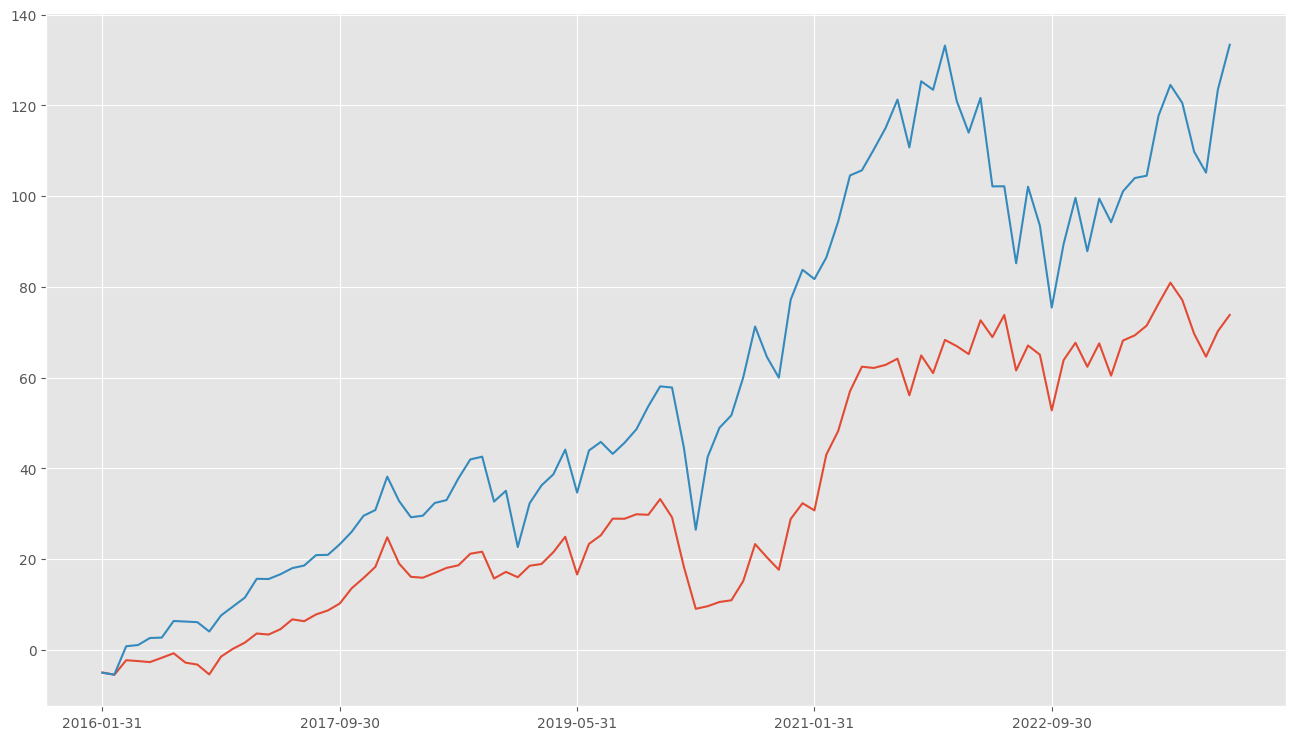

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()
print("STRATEGY vs. BENCHMARK")